### PyTorch Deep lizard 2
Fashion MNIST https://github.com/zalandoresearch/fashion-mnist
Training a simple convolutional neural network from scratch

In [1]:
import sys
sys.path.append('/home/abhinav.sunderrajan/miniconda3/lib/python3.6/site-packages')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import torch
import torchvision
from torchvision import *
import torch.nn as nn
import torch.nn.functional as F
torch.set_printoptions(linewidth=120)

### Extract and transform phase
Extract from the url and do the required transformation. We can see we have gotten 60k training data

In [2]:
train_set=torchvision.datasets.FashionMNIST(root='./data/FashionMNIST',train=True,download=True,\
            transform=transforms.Compose([transforms.ToTensor()]))
len(train_set)

60000

### Data loaders
Creates the batches that we will feed to the neural network

In [3]:
train_loader=torch.utils.data.DataLoader(train_set,batch_size=32)
len(train_loader)

1875

### Get the test data as well

In [4]:
test_dataset = torchvision.datasets.FashionMNIST(root='./data/FashionMNIST',download=True,train=False,\
            transform=transforms.Compose([transforms.ToTensor()]))

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=32, shuffle=False)
len(test_dataset),len(test_loader)

(10000, 313)

#### Train labels
It is neatly balanced dataset with 6000 labels for each class, remeber there are 10 classes and the size of training set is 60k.

In [5]:
print(train_set.train_labels)
train_set.train_labels.bincount()

tensor([9, 0, 0,  ..., 3, 0, 5])


tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [6]:
images,labels=next(iter(train_loader))
images.shape,labels.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [7]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

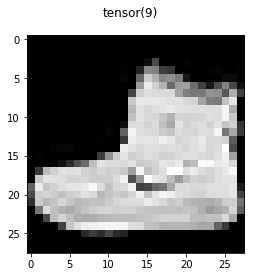

In [8]:
fig, ax = plt.subplots(1,1)
fig.suptitle(labels[0], fontsize=12)
ax.imshow(images[0].squeeze(),cmap="gray")

#### Plotting the whole batch

torch.Size([3, 122, 242])
torch.Size([122, 242, 3])


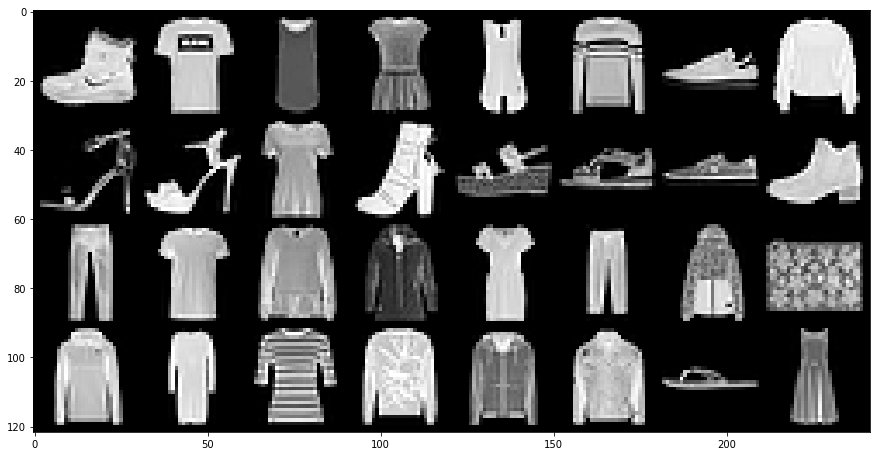

In [9]:
#nrow tells the number of images in each row
grid=torchvision.utils.make_grid(images,nrow=8)
print(grid.shape)
plt.figure(figsize=(15,15))
print(np.transpose(grid,(1,2,0)).shape)
plt.imshow(np.transpose(grid,(1,2,0)))

### Build the CNN model
Noet that maxpool size=2 and stride=2 reduces an input by half. For eg $28*28$ becomes $14*14$ after maxpool. Formula for calculating output of convolution is $O=\frac{I-K+2P}{S}+1$ Where $O$ is the size of output and $I,K,P \text{ and } S$ represent the sizes of input, kernel, padding and size respectively.

In [43]:
class Network(nn.Module):
    def __init__(self,num_classes=10):
        super(Network, self).__init__()
        #super()
        super(Network, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout(0.4)
        self.fc1 = nn.Linear(7*7*32, num_classes)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out=self.drop_out(out)
        out = self.fc1(out)
        return out
        
        
    

In [44]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_classes=10
learning_rate=1e-3
num_epochs=10

In [45]:
# Loss and optimizer
#criterion = nn.BCEWithLogitsLoss()
model_pytorch = Network(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_pytorch.parameters(),learning_rate, weight_decay=5e-4,momentum=0.9)

### Evaluation

In [46]:
# Test the model
def evaluate_and_print_results(model):
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            #labels=one_hot_embedding(labels,num_classes)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

### Train the model

In [47]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        #labels=one_hot_embedding(labels,num_classes)
        labels = labels.to(device)
        
        
        # Forward pass
        outputs = model_pytorch(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 1875 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/10], Step [1875/1875], Loss: 0.4513
Epoch [2/10], Step [1875/1875], Loss: 0.4451
Epoch [3/10], Step [1875/1875], Loss: 0.2979
Epoch [4/10], Step [1875/1875], Loss: 0.2782
Epoch [5/10], Step [1875/1875], Loss: 0.1802
Epoch [6/10], Step [1875/1875], Loss: 0.2919
Epoch [7/10], Step [1875/1875], Loss: 0.2110
Epoch [8/10], Step [1875/1875], Loss: 0.1715
Epoch [9/10], Step [1875/1875], Loss: 0.2631
Epoch [10/10], Step [1875/1875], Loss: 0.2091


In [48]:
evaluate_and_print_results(model_pytorch)

Test Accuracy of the model on the 10000 test images: 89.98 %


### FastAI
I am actually using resnet34 not sure if it is required.

In [49]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *

In [50]:
print(torch.__version__,torch.cuda.is_available())

0.4.1 True


In [51]:
img=train_set.train_data.float().numpy().reshape(-1,28,28)
test_img=test_dataset.test_data.float().numpy().reshape(-1,28,28)
img.shape,test_img.shape

((60000, 28, 28), (10000, 28, 28))

In [52]:
img=np.stack((img,)*3, axis=-1).astype('float32')
test_img=np.stack((test_img,)*3, axis=-1).astype('float32')
img.shape,test_img.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [53]:
lbl=train_set.train_labels.numpy()
test_lbl=test_dataset.test_labels.numpy()
lbl.shape,test_lbl.shape

((60000,), (10000,))

In [54]:
arch=resnet34
sz=28

In [71]:
data_mnist=ImageClassifierData.from_arrays(train_set.root,(img/255,lbl),
                               (test_img/255,test_lbl),
                                bs=32,classes=np.unique(test_dataset.test_labels.numpy()).tolist(),
                                tfms=tfms_from_model(arch, sz,aug_tfms=transforms_side_on, max_zoom=1.1))

x,y=to_np(next(iter(data_mnist.val_dl)))
print(x.shape,y.shape)

#train_set.train_data.float().dtype

(32, 3, 28, 28) (32,)


In [72]:
learn = ConvLearner.pretrained(arch, data_mnist, precompute=False)

/usr/local/lib/python3.6/dist-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/usr/local/lib/python3.6/dist-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


 76%|███████▌  | 1420/1875 [00:38<00:13, 33.45it/s, loss=3.36] 

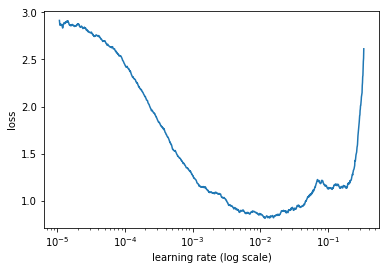

 76%|███████▌  | 1420/1875 [00:49<00:13, 33.45it/s, loss=3.36]

In [73]:
lrf=learn.lr_find()
learn.sched.plot()

In [74]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                      
    0      0.647104   0.517528   0.8131    
    1      0.604038   0.494783   0.8208                        
    2      0.550751   0.47169    0.8282                        


[0.4716896191120148, 0.8282]

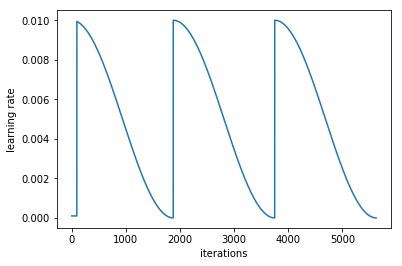

In [75]:
learn.sched.plot_lr()

In [76]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)


epoch      trn_loss   val_loss   accuracy                      
    0      0.445292   0.363652   0.8692    
    1      0.359187   0.310707   0.8878                        
    2      0.32029    0.293552   0.8921                        
    3      0.334598   0.281131   0.9011                        
    4      0.303      0.269578   0.9021                        
    5      0.280176   0.25684    0.9064                        
    6      0.24212    0.253881   0.9104                        


[0.25388149752616884, 0.9104]

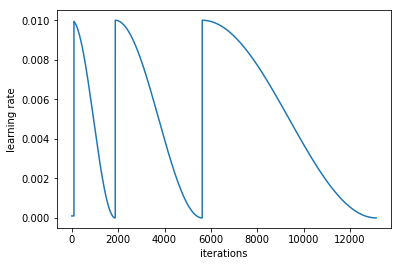

In [77]:
learn.sched.plot_lr()

In [78]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [79]:
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9136, 0.245910794549309)

In [82]:
??accuracy_np

### Some simple stuff

In [ ]:
loss = nn.CrossEntropyLoss()
num_classes=8
x=torch.randn(3,num_classes)
target = torch.empty(3, dtype=torch.long).random_(num_classes)
print(x)
print(target)
loss(x,target)